# Rutgers AZFP data processing from a glider

2023-5-4. Emilio Mayorga

## Introduction

- Southern Ocean Slocum glider data from 2018, from a single dive. Data and background information provided by Delphine Mossman, Department of Marine and Coastal Sciences, Rutgers University
- In the Ross Sea. 15 minutes of AZFP echosounder data, from a single dive.

### Goals

### Description

### Running the notebook

This is temporary, during notebook development

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import echopype as ep
import echopype.visualize as epviz

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

# Reset this when ready to go live, to make it less verbose
from echopype import verbose
verbose()

In [3]:
data_dpath = Path('./data')

## Open and convert raw AZFP data

In [4]:
ed = ep.open_raw(
    data_dpath / "18011107.01A", 
    xml_path=data_dpath / "18011107.XML", 
    sonar_model="AZFP"
)

2023-05-02 01:02:13,368:echopype.convert.parse_azfp:INFO: parsing file 18011107.01A with 18011107.XML, time of first ping: 2018-Jan-11 07:44:40
2023-05-02 01:02:13,794:echopype.utils.prov:INFO: EchoData object (converted raw file) does not contain valid Platform location data. Processing level attributes will not be added.


In [5]:
ed

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

AZFP raw data files don't store latitude and longitude data. Therefore, the `Platform` group does not contain such data (or the variables).

In [6]:
"latitude" in ed["Platform"].data_vars, "longitude" in ed["Platform"].data_vars

(False, False)

As this echosounder is deployed on a glider that collects independent CTD data, the temperature sensor is disabled. The `temperature` variable is filled with `nan`.

In [7]:
ed["Environment"]

<xarray.Dataset>
Dimensions:      (time1: 920)
Coordinates:
  * time1        (time1) datetime64[ns] 2018-01-11T07:44:40 ... 2018-01-11T07...
Data variables:
    temperature  (time1) float64 nan nan nan nan nan nan ... nan nan nan nan nan

## Open external glider data netCDF file

The glider data are available at http://slocum-data.marine.rutgers.edu/erddap/tabledap/ru32-20180109T0531-profile-sci-delayed.html. We previously downloaded and subset that dataset.

In [8]:
glider_nc_fname = data_dpath / "ru32-20180109T0531-profile-sci-delayed-subset.nc"

In [9]:
glider_ds = xr.open_dataset(glider_nc_fname)
glider_ds

<xarray.Dataset>
Dimensions:                    (time: 915)
Coordinates:
  * time                       (time) datetime64[ns] 2018-01-11T07:26:20.3205...
Data variables: (12/59)
    latitude                   (time) float64 ...
    longitude                  (time) float64 ...
    depth                      (time) float32 ...
    trajectory                 (time) object ...
    source_file                (time) object ...
    beta_700nm                 (time) float32 ...
    ...                         ...
    sci_water_pressure         (time) float32 ...
    sound_speed                (time) float32 ...
    temperature                (time) float32 ...
    u                          (time) float32 ...
    v                          (time) float32 ...
    water_depth                (time) float32 ...
Attributes: (12/72)
    cdm_data_type:                   Profile
    cdm_profile_variables:           profile_id
    comment:                         Glider was deployed/recovered from the R...
    contributor_name:                Grace Saba, Dave Aragon, Chip Haldeman, ...
    contributor_role:                Principal Investigator, Glider Pilot, Gl...
    Conventions:                     CF-1.6, COARDS, ACDD-1.3
    ...                              ...
    time_coverage_resolution:        PTS
    time_coverage_start:             2018-01-09T05:29:54Z
    title:                           ru32-20180109T0531 Delayed Science Profile
    uuid:                            82c40f91-87ab-40bb-a1ea-3f1c366a0378
    Westernmost_Easting:             164.36469500000004
    wmo_id:                          7801506

The external glider data time range encompasses that of the AZFP data.

In [10]:
glider_ds.time.min().values, glider_ds.time.max().values

(numpy.datetime64('2018-01-11T07:26:20.320559872'),
 numpy.datetime64('2018-01-11T08:00:28.788059904'))

In [11]:
ed["Sonar/Beam_group1"]["ping_time"].min().values, ed["Sonar/Beam_group1"]["ping_time"].max().values

(numpy.datetime64('2018-01-11T07:44:40.000000000'),
 numpy.datetime64('2018-01-11T07:59:59.000000000'))

## Update EchoData Platform with glider latitude and longitude data

**NOTE / TODO:** 
- `water_level` is modified and a `time1` dimension added, but that's wrong. Change it to `time3` (or leave it as a scalar, as found after `open_raw`?

The external glider file name is used in `update_platform` only to store it as provenance recording the origin of the data.

In [12]:
ed.update_platform(
        glider_ds,
        extra_platform_data_file_name=glider_nc_fname.name,
)

In [13]:
ed['Platform']

<xarray.Dataset>
Dimensions:              (time2: 920, time1: 872)
Coordinates:
  * time2                (time2) datetime64[ns] 2018-01-11T07:44:40 ... 2018-...
  * time1                (time1) datetime64[ns] 2018-01-11T07:26:30.393129984...
Data variables: (12/20)
    tilt_x               (time2) float64 nan nan nan nan nan ... nan nan nan nan
    tilt_y               (time2) float64 nan nan nan nan nan ... nan nan nan nan
    MRU_offset_x         float64 nan
    MRU_offset_y         float64 nan
    MRU_offset_z         float64 nan
    MRU_rotation_x       float64 nan
    ...                   ...
    pitch                (time1) float64 nan nan nan nan nan ... nan nan nan nan
    roll                 (time1) float64 nan nan nan nan nan ... nan nan nan nan
    vertical_offset      (time1) float64 nan nan nan nan nan ... nan nan nan nan
    latitude             (time1) float64 -75.02 -75.02 -75.02 ... -75.02 -75.02
    longitude            (time1) float64 165.5 165.5 165.5 ... 165.5 165.5 165.5
    water_level          (time1) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    platform_name:       
    platform_type:       
    platform_code_ICES:

### Plot glider location

Extract and join the `latitude` and `longitude` variables from the `Platform` group in the `ed` EchoData object. Convert to a `Pandas` DataFrame first, then to a `GeoPandas` GeoDataFrame for convenient viewing and manipulation.

In [14]:
gps_df = ed['Platform'].latitude.to_dataframe().join(ed['Platform'].longitude.to_dataframe())
gps_df.head(3)

,latitude,longitude
time1,,
2018-01-11 07:26:30.393129984,-75.018896,165.499855
2018-01-11 07:48:05.826169856,-75.017433,165.500057
2018-01-11 07:48:06.832060416,-75.017432,165.500058


In [15]:
(gps_df.longitude.min(), gps_df.longitude.max()), (gps_df.latitude.min(), gps_df.latitude.max())

((165.49765868921702, 165.50005833333333),
 (-75.01889590423247, -75.01737333333334))

In [16]:
gps_gdf = gpd.GeoDataFrame(
    gps_df,
    geometry=gpd.points_from_xy(gps_df['longitude'], gps_df['latitude']), 
    crs="epsg:4326"
)

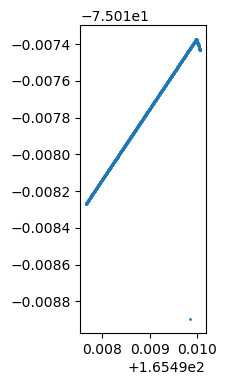

In [17]:
gps_gdf.plot(markersize=1, figsize=(2,4));

Plot using a South Polar Stereo map projection.

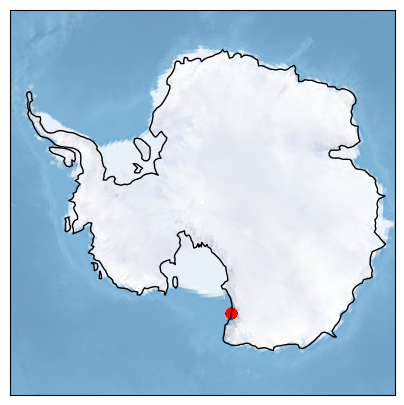

In [18]:
_, ax = plt.subplots(
    figsize=(5, 5), subplot_kw={"projection": ccrs.SouthPolarStereo()}
)
ax.set_extent([-180, 180, -90, -65], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
ax.stock_img()
# ax.gridlines()
gps_gdf.plot(ax=ax, markersize=50, color='red', transform=ccrs.PlateCarree(), aspect=None);

## Calibrate with glider mean environmental data

In [19]:
env_params_means = {}
for env_var in ["temperature", "salinity", "pressure"]:
    env_params_means[env_var] = float(glider_ds[env_var].mean().values)

In [20]:
env_params_means

{'temperature': -1.020638108253479,
 'salinity': 34.53363037109375,
 'pressure': 38.693416595458984}

In [21]:
Sv_ds = ep.calibrate.compute_Sv(ed, env_params=env_params_means)
Sv_ds

<xarray.Dataset>
Dimensions:                (channel: 3, ping_time: 920, range_sample: 1999,
                            filenames: 1, time1: 872)
Coordinates:
  * channel                (channel) <U11 '59006-38-1' ... '59006-200-3'
  * ping_time              (ping_time) datetime64[ns] 2018-01-11T07:44:40 ......
  * range_sample           (range_sample) int64 0 1 2 3 ... 1995 1996 1997 1998
  * filenames              (filenames) int64 0
  * time1                  (time1) datetime64[ns] 2018-01-11T07:26:30.3931299...
Data variables: (12/18)
    Sv                     (channel, ping_time, range_sample) float64 -113.9 ...
    echo_range             (channel, ping_time, range_sample) float64 0.3611 ...
    frequency_nominal      (channel) float64 3.8e+04 1.25e+05 2e+05
    sound_speed            float64 1.444e+03
    sound_absorption       (channel) float64 0.009111 0.03012 0.04501
    temperature            float64 -1.021
    ...                     ...
    TVR                    (channel) float64 156.2 168.5 165.9
    VTX                    (channel) float64 157.0 146.7 133.3
    equivalent_beam_angle  (channel) float64 0.1306 0.01071 0.01071
    Sv_offset              (channel) float64 0.7 0.3 0.3
    source_filenames       (filenames) <U17 'data/18011107.01A'
    water_level            (time1) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.6.4.dev112+g196bd6b2.d20230417
    processing_time:              2023-05-02T08:02:16Z
    processing_function:          calibrate.compute_Sv

### Add latitude, longitude and depth to Sv

Notice the use of chained `consolidate` functions.

In [22]:
Sv_ds = ep.consolidate.add_depth(ep.consolidate.add_location(Sv_ds, ed))

## Plot echograms

**NOTE / TODO:** 
- `ep.visualize` (in the `import` statement?) ought to work (right?), but `visualize` is not exposed in `__init__.py`
- Don't know if there's way to display "depth" rather than "range"
- Looks like `create_echogram` needs more work for it to work with frequencies rather than channel. Part of it involves assumptions about variable names `frequency` vs `frequency_nominal`.

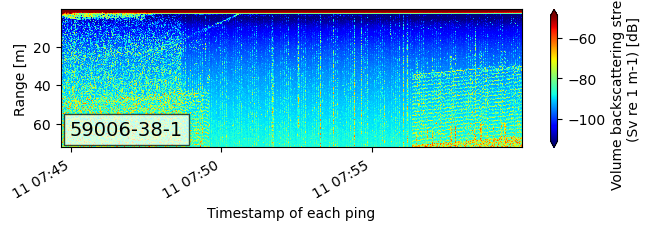

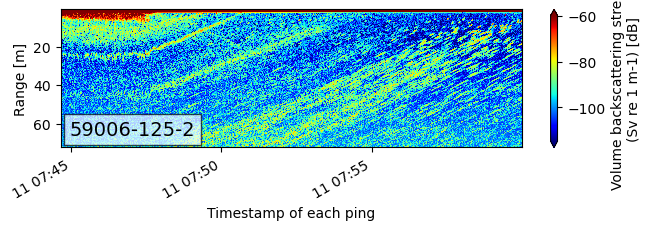

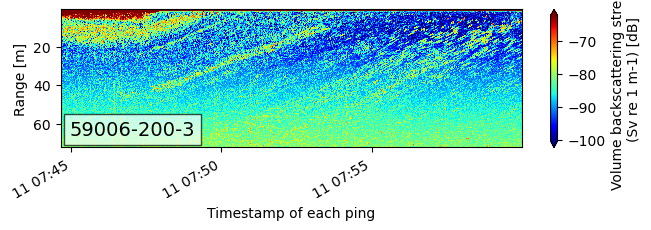

In [23]:
# NOTE: robust is an xarray plot pcolormesh argument
epviz.create_echogram(Sv_ds, robust=True, figsize=(8,5));

## Package versions

In [24]:
import datetime
print(f"echopype: {ep.__version__}, xarray: {xr.__version__}, geopandas: {gpd.__version__}")

print(f"\n{datetime.datetime.utcnow()} +00:00")

echopype: 0.6.4.dev112+g196bd6b2.d20230417, xarray: 2022.3.0, geopandas: 0.12.2

2023-05-02 08:02:22.137125 +00:00
